# Clase 16 
# Chat with your Own Data: Datos estructurados 

## Objetivo de la clase

* Aprender a implementar aplicaciones basadas en Azure OpenAI Service que sean capaces de responder consultas usando datos de tablas de una base de datos Azure SQL.  
* Aprender a usar la vectorización integrada de Azure AI Search



## Vectorización integrada de Azure AI Search

En este ejemplo tomaremos como referencia la siguiente arquitectura:

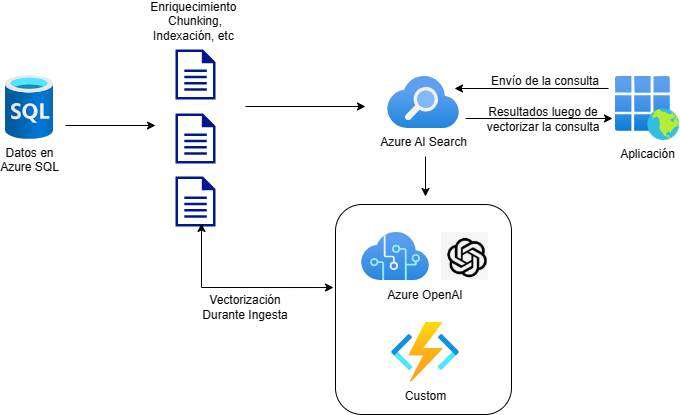

* La base de datos Azure SQL contiene una tabla llamada TICKET, la cual contiene información acerca de tickets que han presentado los usuarios sobre ciertos productos. 
* El servicio de Azure Search indexa los datos de la de datos, creando un proceso de chunking que permite fragmentar los datos de cada fila de la base de datos, para posteriormente incluir en este un elemento por cada chunk generado junto con su representación vectorial. 
* El servicio de Azure OpenAI es usado para generar las representaciones vectoriales de los chunks usando un modelo ada. 
* Las aplicaciones pueden consultar Azure AI Search para implementar una búsqueda por similitud vectorial o pueden usar estos resultados para crear un contexto que pueda ser usado por un modelo de GPT.  



## Requisitos previos
1. Instale los paquetes descritos en requirements.txt. 

        ! pip install requirements.txt --quiet
2. Instale el paquete [azure-search-documents](whl/azure_search_documents-11.4.0b12-py3-none-any.whl). Disponible en la carpeta [whl](whl).
3. Despliegue una base de datos Azure SQL que soporte autenticación SQL.
4. Cree la tabla Ticket e inserté los registros usando el script sql.sql adjunto a este notebook.
5. Despliegue una instancia de Azure AI Search.
6. Despliegue un recurso de Azure OpenAI Service junto con un modelo de ada y un modelo GPT con la API de Completions.
7. Configure los endpoints y claves de los servicios de Azure OpenAI y Azure AI search junto los  datos de acceso a la BD en ```.env```

## Set Up: Claves y variables de entorno

In [ ]:
from dotenv import load_dotenv  
import os   
  
# Confugurar variables de entorno
load_dotenv()  

In [ ]:
# Cargar los datos de conexión a la base de datos Azure SQL 
server = os.getenv["server"] 
database = os.getenv["database"] 
username = os.getenv["username"] 
password = os.getenv["password"] 
driver = '{ODBC Driver 18 for SQL Server}'

In [ ]:
# Cargar los datos del modelo desplegado en Azure OpenAI
import openai
openai.api_type = os.getenv["openai_api_type"]
openai.api_key = os.getenv['openai_api_key']
openai.api_base = os.getenv['openai_api_base']
openai.api_version = os.getenv['openai_api_version'] 
openai_deployment = os.getenv["openai_deployment_embedding"] # Nombre del modelo desplegado en Azure OpenAI para hacer embeddings
EMBEDDING_LENGTH = 1536

In [ ]:
# Cargar los datos del servicio de AI search 
cogsearch_key = os.getenv["cogsearch_api_key"]
service_endpoint = os.getenv["cogsearch_endpoint"]
index_name = os.getenv["cogsearch_index_name"] #  Nombre del indice que se creará o que ya está creado en Azure AI Search


## Establecer la conexión a la fuente de datos en Azure AI Search 

### Importar funciones para la configuración de Azure AI Search

In [ ]:
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient, SearchIndexerClient  
from azure.search.documents.models import (
    QueryAnswerType,
    QueryCaptionType,
    QueryLanguage,
    QueryType,
    RawVectorQuery,
    VectorizableTextQuery,
    VectorFilterMode,    
)
from azure.search.documents.indexes.models import (  
    AzureOpenAIEmbeddingSkill,  
    AzureOpenAIParameters,  
    AzureOpenAIVectorizer,  
    ExhaustiveKnnParameters,  
    ExhaustiveKnnVectorSearchAlgorithmConfiguration,
    FieldMapping,  
    HnswParameters,  
    HnswVectorSearchAlgorithmConfiguration,  
    IndexProjectionMode,  
    InputFieldMappingEntry,
    MergeSkill,
    OutputFieldMappingEntry,  
    PrioritizedFields,    
    SearchField,  
    SearchFieldDataType,  
    SearchIndex,  
    SearchIndexer,  
    SearchIndexerDataContainer,  
    SearchIndexerDataSourceConnection,  
    SearchIndexerIndexProjectionSelector,  
    SearchIndexerIndexProjections,  
    SearchIndexerIndexProjectionsParameters,  
    SearchIndexerSkillset,  
    SemanticConfiguration,  
    SemanticField,  
    SemanticSettings,  
    SplitSkill,  
    SqlIntegratedChangeTrackingPolicy,
    VectorSearch,  
    VectorSearchAlgorithmKind,  
    VectorSearchAlgorithmMetric,  
    VectorSearchProfile,  
)  

### Crear la conexión a la fuente de datos

En este paso vamos a crear la conexión que se usará para traer los datos de la tabla SQL

In [ ]:
table_name = "Ticket" # Nombre de la tabla de la base de datos Azure SQL que se va a indexar en Azure AI Search

In [ ]:
ds_conn_str = f'Encrypt=True;TrustServerCertificate=False;Connection Timeout=30;Server=tcp:{server};Database={database};User ID={username};Password={password};'

cogsearch_credential = AzureKeyCredential(cogsearch_key) # Credenciales del servicio de Azure AI Search
ds_client = SearchIndexerClient(service_endpoint, cogsearch_credential)
container = SearchIndexerDataContainer(name=table_name) 

change_detection_policy = SqlIntegratedChangeTrackingPolicy() # Configuración de la política de detección de cambios en la base de datos Azure SQL

data_source_connection = SearchIndexerDataSourceConnection(
    name=f"{index_name}-azuresql-connection",# Nombre de la conexión a la base de datos Azure SQL en Azure AI Search
    type="azuresql", # Tipo de conexión en Azure AI Search
    connection_string=ds_conn_str,
    container=container,
    data_change_detection_policy=change_detection_policy
)
data_source = ds_client.create_or_update_data_source_connection(data_source_connection)

print(f"Data source '{data_source.name}' created or updated")

## Configuración: Chuncking + Vectorización + Indexación

### Crear Índice 

En este paso vamos a indexar los datos de la tabla de base de datos siguiendo:
1. tomar la información de cada producto . 
2. Aplicar chunking al texto de cada producto. 
3. Aplicar embedding a cada chunk 

Para soportar la búsqueda del chunk o chunks más relevantes según una consulta entrante, debemos habilitar un índice en Azure AI Search para cada chunck y guardar la siguiente información:

* id chunk 
* texto (chunk)
* Representación Vectorial del chunk
* ID del Ticket (TicketID)
* Tipo de ticket (TicketType)
* Nombre del Producto (ProductPurchased)
* Tema del Ticket (TicketSubject)
* Descripción del Ticket (TicketDescription)
* Evaluación Cliente (CustomerSatisfactionRating)

Estos valores serán guardados en SearchFields como se muestra en la siguiente celda.

In [ ]:
# Create a search index
index_client = SearchIndexClient(
    endpoint=service_endpoint, credential=cogsearch_credential)

fields = [
    # Propiedades de un chunk individual 
    SearchField(name="Id", type=SearchFieldDataType.String, key=True,
                sortable=True, filterable=True, facetable=True, analyzer_name="keyword"),
    SearchField(name="chunk", type=SearchFieldDataType.String, sortable=False, filterable=False, facetable=False),
    SearchField(name="vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
                vector_search_dimensions=EMBEDDING_LENGTH, vector_search_profile="my-vector-search-profile"),
    # Propiedades de la fila original de la Base de datos a la que el chunk pertenecen 
    SearchField(name="parent_id_ticket", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),
    SearchField(name="parent_ticket_type", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),
    SearchField(name="parent_product_purchased", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),
    SearchField(name="parent_ticket_subject", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),
    SearchField(name="parent_ticket_description", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),
    SearchField(name="parent_customer_satisfaction", type=SearchFieldDataType.Int64, sortable=True, filterable=True, facetable=True)
]

# Establecer la configuración de la búsqueda vectorial  
vector_search = VectorSearch(
    algorithms=[
        HnswVectorSearchAlgorithmConfiguration(
            name="my-hnsw-config",
            kind=VectorSearchAlgorithmKind.HNSW
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="my-vector-search-profile",
            algorithm="my-hnsw-config",
            vectorizer="my-openai" # Nombre del vectorizador que se creará a continuación (basado en el modelo de OpenAI)
        )
    ],
    vectorizers=[
        AzureOpenAIVectorizer(
            name="my-openai",
            kind="azureOpenAI",
            azure_open_ai_parameters=AzureOpenAIParameters(
                resource_uri=openai.api_base,
                deployment_id=openai_deployment,
                api_key=openai.api_key
            )
        )  
    ]  
)

semantic_config = SemanticConfiguration(
    name="my-semantic-config",
    prioritized_fields=PrioritizedFields(
        prioritized_content_fields=[SemanticField(field_name="Id")]
    )
)

# Establecer la configuración semántica 
semantic_settings = SemanticSettings(configurations=[semantic_config])

# Crear el índice de búsqueda con la configuración semántica 
index = SearchIndex(name=index_name, fields=fields,
                    vector_search=vector_search, semantic_settings=semantic_settings)
result = index_client.create_or_update_index(index)
print(f'{result.name} created')


### Crear el Skillset

Para la creación del skillset usamos 2 skills preconstruidos

1. Split skill: toma el texto concatenado y lo divide (chunks) con el fin que cada chunk cumpla con los límites de tokens del modelo de embedding en Azure OpenAI.
2. Azure Open AI Embedding Skill: toma los chunks y los vectoriza de forma individual. 

Ahora, por cada chunk debe existir en el índice final un elemento por cada chunk, en lugar de uno por cada fila de la tabla de la base de datos. 

In [ ]:
# Create a skillset  
skillset_name = f"{index_name}-skillset"

split_skill = SplitSkill(  
    description="Split skill to chunk documents",  
    text_split_mode="pages",  
    context="/document",  
    maximum_page_length=300,  
    page_overlap_length=20,  
    inputs=[  
        InputFieldMappingEntry(name="text", source="/document/TextConcat"),  
    ],  
    outputs=[  
        OutputFieldMappingEntry(name="textItems", target_name="pages")  
    ]  
)

embedding_skill = AzureOpenAIEmbeddingSkill(  
    description="Skill to generate embeddings via Azure OpenAI",  
    context="/document/pages/*",  
    resource_uri=openai.api_base,  
    deployment_id=openai_deployment,  
    api_key=openai.api_key,  
    inputs=[  
        InputFieldMappingEntry(name="text", source="/document/pages/*"),  
    ],  
    outputs=[  
        OutputFieldMappingEntry(name="embedding", target_name="vector")  
    ]  
)  

index_projections = SearchIndexerIndexProjections(  
    selectors=[  
        SearchIndexerIndexProjectionSelector(  
            target_index_name=index_name,  
            parent_key_field_name="parent_id", # Note: this populates the "parent_id" search field
            source_context="/document/pages/*",  
            mappings=[  
                InputFieldMappingEntry(name="chunk", source="/document/pages/*"),
                InputFieldMappingEntry(name="vector", source="/document/pages/*/vector"),
                InputFieldMappingEntry(name="parent_product_purchased", source="/document/ProductPurchased"),
                InputFieldMappingEntry(name="parent_ticket_type", source="/document/TicketType"),
                InputFieldMappingEntry(name="parent_ticket_subject", source="/document/TicketSubject"),
                InputFieldMappingEntry(name="parent_ticket_description", source="/document/TicketDescription"),
                InputFieldMappingEntry(name="parent_customer_satisfaction", source="/document/CustomerSatisfactionRating")
            ],  
        ),  
    ],
)  


skillset = SearchIndexerSkillset(  
    name=skillset_name,  
    description="Skillset to chunk documents and generating embeddings",  
    skills=[split_skill, embedding_skill],
    index_projections=index_projections  
)
  
client = SearchIndexerClient(service_endpoint, cogsearch_credential)  
client.create_or_update_skillset(skillset)  
print(f' {skillset.name} created')

### Crear Indexador

In [ ]:
# Crear el indexador que se encargará de indexar los datos de la base de datos Azure SQL en Azure AI Search 
indexer_name = f"{index_name}-indexer"  

indexer = SearchIndexer(  
    name=indexer_name,  
    description="Indexer to chunk documents and generate embeddings",  
    skillset_name=skillset_name,  
    target_index_name=index_name,  
    data_source_name=data_source.name
)  
  
indexer_client = SearchIndexerClient(service_endpoint, cogsearch_credential)
indexer_result = indexer_client.create_or_update_indexer(indexer)  

#  Ejecutar el indexador para que empiece a indexar los datos de la base de datos Azure SQL en Azure AI Search
indexer_client.run_indexer(indexer_name)
print(f' {indexer_name} created')

In [ ]:
# Consultar el estado del indexador 
indexer_status = indexer_client.get_indexer_status(indexer_name)
print(f"Indexer status: {indexer_status.status}")

### Búsqueda vectorial 

Cuando el estado del indexador sea ```Finalizado``` ejecuta las siguientes celdas, de lo contrario podrías obtener un error.  

In [ ]:
query = "Go Pro"

In [ ]:
search_client = SearchClient(service_endpoint, index_name, credential=cogsearch_credential)
vector_query = VectorizableTextQuery(text=query, k=5, fields="vector", exhaustive=True)

  
results = search_client.search(
    search_text=None,  
    vector_queries= [vector_query],
    select=["Id", "parent_id_ticket", "chunk", "parent_product_purchased", "parent_ticket_type", "parent_ticket_subject", "parent_ticket_description", "parent_customer_satisfaction"],
    top=5
)



for result in results:
    print(f"Puntuación de la búsqueda: {result['@search.score']}")
    print(f"Id: {result['parent_id_ticket']} | Chunk id: {result['Id']}")
    print(f"Producto Comprado: {result['parent_product_purchased']}")
    print(f"Chunk: {result['chunk']}") 
    print(f"Tipo de Ticket: {result['parent_ticket_type']}")
    print(f"Tema: {result['parent_ticket_subject']}")
    print(f"Descripción: {result['parent_ticket_description']}")
    print(f"Satisfacción (Puntuación): {result['parent_customer_satisfaction']}")
    print("-----")



## GPT y Azure AI Search

Prompt 

In [ ]:
# Crear un prompt para generar una respuesta a la consulta del usuario
template = """
     La consulta del usuario es: {query}
     La descripción del ticket más relevante es: {context}
     El usuario está buscando tickets que coincidan con  su consulta.
     Dígale al usuario que después de buscar en nuestra base de datos de tickets, se muestra el producto descrito en el ticket.
     Su respuesta debe resumir el texto de descripción del ticket más relevante.
     incluya la identificación del producto y mencione la puntuación otorgada por el cliente.
    """

In [ ]:
# Regenerar los resultados 
# Crear el contexto a partir de la respuesta de  búsqueda. 
results = search_client.search(
    search_text=None,  
    vector_queries= [vector_query],
    select=["Id", "parent_id_ticket", "chunk", "parent_product_purchased", "parent_ticket_type", "parent_ticket_subject", "parent_ticket_description", "parent_customer_satisfaction"],
    top=1
)

context = ""
for result in results:
    context += f"Producto: {result['parent_product_purchased']}. Descripción del ticket: {result['parent_ticket_description']}. Nivel de Satisfacción: {result['parent_customer_satisfaction']}"
    
print(context)

In [ ]:
prompt = template.format(context=context, query=query)
print(prompt)

### Búsqueda Híbrida

**Llamando a OpenAI**

In [ ]:
response = openai.Completion.create(
    engine= os.getenv["openai_deployment_completion"],
    prompt=prompt,
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=1,
)

print(response['choices'][0]['text'])

# Conclusiones 

En esta clase aprendimos a crear una representación vectorial de una base de datos Azure SQL usando Azure AI Search y Azure OpenAI, lo que nos permitió soportar búsquedas por similitud y usar los  resultados de esta búsqueda para generar un contexto que sea usado por los modelos de GPT, de tal manera que podamos chatear con nuestros datos estructurados de una tabla SQL.  
Ahora, implementa un asistente virtual que te permita chatear con los datos de tu Base de datos Azure SQL. 
